Task 1 - Random Walk Segmentation

In [58]:
# imports task 1
import imageio
from utils_rw_scribble import *

# open images
img_gray = torch.from_numpy(imageio.imread('CT_image_gray.png')).float()#/255
print(img_gray.shape)
scribbles = torch.from_numpy(imageio.imread('CT_image_scribble.png')).long()
print(scribbles.shape)

torch.Size([306, 228])
torch.Size([306, 228, 3])


/Users/falcolentzsch/Develope/FVMB/FVMB/exercise_5/utils_rw_scribble.py:35: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unique_red = (unique_colours//(256**2))
/Users/falcolentzsch/Develope/FVMB/FVMB/exercise_5/utils_rw_scribble.py:36: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unique_green = ((unique_colours%(256**2))//256)


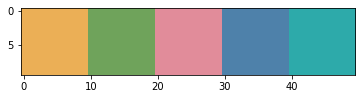

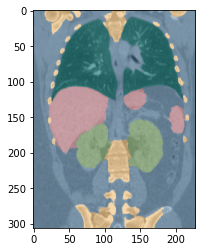

In [60]:
# todo: Random walk implementation
def random_walk(img_gray,labels):
    H,W = img_gray.size()

    # create Sparse La Place Matrix mit Übergangswahrscheinlichkeiten,
    # welche Intensitätsbasiert sind.
    L = laplace_unweighted(img_gray)

    # Bauen einer Maske, die Kanten zu Seedknoten beinhaltet
    mask_colour = (labels.view(-1) != 0)
    # Maske normal und invertiert anwenden für Knoten seeded und unseeded
    x_seeded = torch.arange(H*W)[mask_colour]
    x_unseeded = torch.arange(H*W)[~mask_colour]

    # Kanten in unbekannten Regionen bestimmen. L_u = x_unseeded x x_unseeded
    L_u = sparse_rows(sparse_cols(L,x_unseeded),x_unseeded)
    # Kanten zu Seedknoten. B = x_seeded x x_unseeded
    B_T =  sparse_rows(sparse_cols(L,x_seeded),x_unseeded)
    # B interessiert hier nicht, weil es Kanten von Seedknoten zu Seedknoten währen,
    # für die wir ja schon das label haben.

    # Wissen bis hier zwar, welche Knoten ein label haben, aber nicht welches
    u_x_s = F.one_hot(labels.view(-1)[mask_colour]).float()

    # Bis hier #x6, da erster Eintrag immer 0, da wir nur label 1-5 haben können wir,
    # diesen Eintrag löschen
    u_x_s = u_x_s[:,1:]

    # lineares Gleichungssystem lösen. Hier genau die Gleichung
    # L_u * u(x_u) = -B^T * u(x_s) --> nach x_u auflösen,
    # was hier die Funktion macht.
    # Vektor u_x_u beinhaltet dann für jeden Knoten aus x_unseeded einen Vektor mit 5 Einträgen, der verschiedenen Labelwahrscheinlichkeiten.
    u_x_u = sparseMultiGrid(L_u, -1 * torch.sparse.mm(B_T, u_x_s), 50)

    # Erstellen einer Wahrscheinlichkeits Matrix in der Größe des Bildes.
    # Jeder Pixel bekommt seine 5 Wahrscheinlichkeitswerte als Vektor.
    probabilities = torch.zeros(L.size(0),u_x_u.size(1))
    #probabilities[x_seeded] = u_x_s
    #probabilities[x_unseeded] = u_x_u
    probabilities.scatter_add_(dim=0,index=x_seeded.view(-1,1).repeat(1,5),src=u_x_s)
    probabilities.scatter_add_(dim=0,index=x_unseeded.view(-1,1).repeat(1,5),src=u_x_u)
    probabilities = torch.argmax(probabilities,1)
    return probabilities.view(H, W)

# given: extract scribbles and display colours
# labels beinhaltet Zahlen von 0-5. Jedes label bekommt einen Farbwert.
# Einer ist Hintegrund.
labels,unique_rgb = extract_scribbles(scribbles.long())
display_colours(unique_rgb)

probabilities = random_walk(img_gray=img_gray, labels=labels)
rgb = overlay_segment(img_gray, probabilities, unique_rgb)

plt.imshow(rgb)
plt.show()

Task 2 - Random Ferns Segmentation

In [61]:
# imports task 2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# open data
data = torch.load('datablob2d_ct.pth')
print(data.keys(),data['imgs'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'imgs', 'segs', 'test_img', 'test_seg']) (9, 1, 320, 312)


In [62]:
# given: functions for evaluation and visualisation
def plotOverlay(img_test,pts_test,est_label):
    colors=torch.FloatTensor([0,0,0,225,140,154,199,67,66,78,129,170,162,0,183,240,110,38,111,163,91,235,175,86,202,255,52,45,170,170]).view(-1,3)/255.0
    colors=colors.numpy()
    #convert -1 +1 coordinates to image dimensions (312,320)
    coords_test = (pts_test+1)/2*torch.Tensor([312-1,320-1]).view(1,1,1,2)#*2-1
    #plot coloured segmentation points
    plt.imshow(torch.clamp(img_test.squeeze().data+500,0,1000)/1000,'gray')
    for i in range(1,8):
        plt.plot(coords_test[0,est_label==i,0,0].numpy(),coords_test[0,est_label==i,0,1].numpy(),'.',color=colors[i,:],alpha=0.3,linewidth=2)
    plt.show()

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice


'''
Found this here:
https://stackoverflow.com/questions/55918468/convert-integer-to-pytorch-tensor-of-binary-bits
Etwas an unser Problem angepasst!!!
'''
def bin2dec(b, bits):
    mask = 2 ** torch.arange(bits - 1, -1, -1).view(1,-1,1)
    return torch.sum(mask * b, 1)

In [63]:
# given: prepare image data and extract BRIEF features
torch.manual_seed(0)
# beinhaltet 9 Trainingsbilder 9x1x320x312 zum Training der Ferns
imgs = torch.from_numpy(data['imgs']).float()
# beinhaltet 1 Testbild 1x1x320x312 zum Testen des trainierten Ferns
test_img = torch.from_numpy(data['test_img']).float()
# label/segmentation der Trainingsbilder
segs = torch.from_numpy(data['segs']).long()
# label/segmentation des Testbildes
test_seg = torch.from_numpy(data['test_seg']).long()

# Dimension des bildes 320x312
H,W = imgs.shape[-2:]
layout = 0.6*torch.randn(1,256,2,2)
layout[:,:64,0,:] = 0

def brief(imgs):
    grid = F.affine_grid(torch.eye(2,3).unsqueeze(0).repeat(imgs.size(0),1,1),(imgs.size(0),1,H//4,W//4),align_corners=False).view(imgs.size(0),1,-1,2)
    img_smooth = F.avg_pool2d(imgs,3,stride=1,padding=1)
    features = torch.tanh(2*(F.grid_sample(img_smooth,grid+layout[:,:,:1,:],align_corners=False)\
                             -F.grid_sample(img_smooth,grid+layout[:,:,1:,:],align_corners=False)))
    return features.view(imgs.size(0),layout.size(1),H//4,W//4)

features = brief(imgs)
features_test = brief(test_img)
grid = F.affine_grid(torch.eye(2,3).unsqueeze(0).repeat(imgs.size(0),1,1),(imgs.size(0),1,H//4,W//4),align_corners=False).view(imgs.size(0),1,-1,2)
labels = F.grid_sample(segs.unsqueeze(1).float(),grid,mode='nearest',align_corners=False).long().squeeze()


grid = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H//2,W//2),align_corners=False).view(1,-1,1,2)
gt = F.grid_sample(test_seg.unsqueeze(1).float(),grid,mode='nearest',align_corners=False).long().view(-1)

In [59]:
# Laplace implementation --> given

def laplace_unweighted(im):
    # given: parameters and image dimensions
    sigma = 7.5
    lambda_ = 1
    H,W = im.size()
    # given: create 1D index vector
    ind = torch.arange(H*W).view(H,W)
    # given: select left->right neighbours
    ii = torch.cat((ind[:,1:].reshape(-1,1),ind[:,:-1].reshape(-1,1)),1)
    # todo: replace val=1 with exponential edge weighting
    #val = torch.ones(ii.size(0))
    val = torch.exp( -((im.flatten()[ii[:,0]] - im.flatten()[ii[:,1]]).pow(2)) / (2*sigma**2) )

    # given: create first part of neigbourhood matrix (similar to setFromTriplets in Eigen)
    A = torch.sparse.FloatTensor(ii.t(), val, torch.Size([H*W,H*W]))
    # given: select up->down neighbours
    ii = torch.cat((ind[1:,:].reshape(-1,1),ind[:-1,:].reshape(-1,1)),1)
    #val = torch.ones(ii.size(0))
    # todo: replace val=1 with exponential edge weighting (as above)
    val = torch.exp( -((im.flatten()[ii[:,0]] - im.flatten()[ii[:,1]]).pow(2)) / (2*sigma**2) )

    # given: create second part of neigbourhood matrix (similar to setFromTriplets in Eigen)
    A = A + torch.sparse.FloatTensor(ii.t(), val, torch.Size([H*W,H*W]))
    # given: make symmetric (add down->up and right->left)
    A = A + A.t()
    # given: compute degree matrix (diagonal sum)
    D = torch.sparse.sum(A,0).to_dense()
    # given: put D and A together
    L = torch.sparse.FloatTensor(torch.cat((ind.view(1,-1),ind.view(1,-1)),0),.00001+lambda_*D,torch.Size([H*W,H*W]))
    L += (A*(-lambda_))
    return L

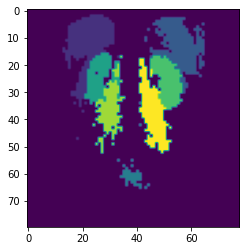

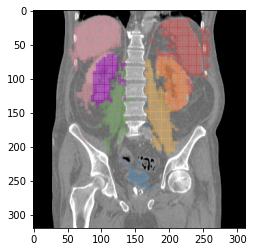

Dice_coeff: tensor([0.7509, 0.7320, 0.6951, 0.8109, 0.9006, 0.6589, 0.7446])


In [68]:
# todo: your random ferns implementation
# Initialisieren einiger Variablen
M = 150 # Anzahl der Ferns
S = 12 # Anzahl der Merkmalstiefe
C = 8 # Anzahl Klassen
# Faktor der die Segmentierung in kritischen Bereichen beeinflusst
# lamda > 1 führt zu mehr falsch positiven, aber Segmentiert die Blase besser
lamda = 0.3
beta = 0.1 * (150 * lamda) # Damit wir nicht beim bilden des Produktes mit 0 multiplizieren
number_pixels = features.shape[2] * features.shape[3]
number_imgs = features.shape[0]

# für jeden der M ferns gibt es S Merkmalsgruppen --> Welche wird hier zufällig festgelegt
feature_idx= torch.randint(high=256, size=(M, S)) # --> wieso 256
# Alle Feature in allen Ferns bekommen den Threshold 0
feature_thresholds = torch.zeros_like(feature_idx)
# bauen der Histogramme / Ferns M x 2^S x C
all_ferns= beta * torch.ones((M, pow(2,S), C))

# Hier bauen wir zunächst unser feature Vektor so um, dass es den shape 256 x Anzahl aller Pixel (9*80*78) hat
# Dann wiederholen wir diesen Vektor M (Anzahl der Ferns) mal für die gather Funktion
# Das gleiche machen wir mit den Indizes. Hier haben wir 150x12 indizes.
# Da wir jetzt die Information aus jedem Pixel ziehen wollen müssen wir unsere Index noch um eine Dimension erweitern --> 150x12xAnzahl Pixel
# Was wir hier also bekommen sind die 12 Random Features für jeden Pixel und das für jeden Fern.
# Im grund haben wir also für jeden Fern für jeden pixel, medes Bildes einen 12 zeichen langen Binären Vektor

features_reshape = features.transpose(0, 1).flatten(start_dim=1).unsqueeze(0).repeat(M,1,1)

features_extracted_binary = torch.gather(input=features_reshape, dim=1, index=feature_idx.unsqueeze(-1).repeat(1,1,number_pixels*number_imgs))
features_extracted_binary = (features_extracted_binary < feature_thresholds.unsqueeze(-1)).int()

# A dieser Stelle haben wir also alle Features in Dezimaldarstellung 110 --> 6 Zahlen von 0 bis 4095
features_extracted_integer = bin2dec(b=features_extracted_binary,bits=S)



# Histogramme jetzt füllen = Training
for m in range(M):
    # der m-te Fern hat 4096 verschiedene Bins 000000000000 - 111111111111
    # Das ganze noch jeweils für 8 Klassen also 4096 * 8 möglihe Zuordnugen im Histogram
    # hierzu flatten wir wie angegeben zunächst das Histogram .view(-1) --> 32768

    # Dann nehmen wir unsere Feature die wir haben nun als Index an. das heißt, wenn wir dass
    # Feature 110 haben, dann hat dies den Integer wert 6, also wollen wir den Zähler, von
    # bin 6 um 1 erhöhen und zwar genau den Bin, der auch der richtigen Label Klasse angehört.
    # Aufbau der Histogramme am Beispiel: 00_class0, 00_class1, 00_class2, 01_class0, 01_class1, 01_class2,...
    # Das ist wichtig für das korrekte einsortieren.

    # Wir haben jetzt für jeden Pixel 9 * 6240 --> 56160 Feature bzw. Integer Indizes extrahiert. Alle mit einem Wert von 0 - 4095
    # Was wir dann im folgenden machen, ist da unsere Indices nur von 0 - 4095 reichen, diese mit *8 auf den ganzen Bereich an möglichen Histogram positionen ab zu bilden. Durch das addieren des labels landen wir dann im richtigen bin.
    # Der Aufbau ist also der folgenden: fern hat 32768 Bins. Die ersten 8 sind alle für den gleichen Wert aber für die unterschiedlichgen 8
    # Klassen. Heißt angenommen Ich habe als Feature die 0. 0 * 8 = 0. Durch addieren des labels ordnen wir es nun der richtigen Klasse zu.
    # Beispiel 2: Wenn Feature = 1 ist. Dann 1 * 8 = 8. Ab hier beginnen die Bins der 8 Klassen für die Zahl 8. Durch addieren des labels,
    # wird wieder zugeordnet
    features_extracted_integer_idx = features_extracted_integer[m] * 8 + labels.view(-1)
    all_ferns[m].view(-1).scatter_add_(dim=0, index=features_extracted_integer_idx,
                      src=torch.ones_like(features_extracted_integer[m], dtype=all_ferns.dtype))


# normalize and logarithmize histograms
all_ferns = torch.log(all_ferns/all_ferns.sum(1, keepdim=True))

'''
Jetzt müssen wir das gleiche für das Testbild machen.
1. Feature extrahieren
2. Feature zu dezimal Index umbauen
3. In allen Histogrammen, Ferns nun die Wahrscheinlichkeiten für die jeweiligen Klassen ansehen.
4. Wahrscheinlichkeiten der verschiedenen Ferns summieren (kein multiplizieren, da log())
5. Argmax pro Pixel wählen und Klasse zuordnen.
'''
# 1.

features_test_reshape = features_test.transpose(0, 1).flatten(start_dim=1).unsqueeze(0).repeat(M,1,1)
test_features_extracted_binary = torch.gather(input=features_test_reshape, dim=1, index=feature_idx.unsqueeze(-1).repeat(1,1,number_pixels))
test_features_extracted_binary = (test_features_extracted_binary < feature_thresholds.unsqueeze(-1)).int()

# 2. A dieser Stelle haben wir also alle Features in Dezimaldarstellung 110 --> 6 Zahlen von 0 bis 4095. HIer nur für ein Bild
test_features_extracted_binary = bin2dec(b=test_features_extracted_binary,bits=S)


# 3. In allen 150 Ferns mit ihren 4096 verschiedenen Bins, welche es für jede der Klassen einmal gibt abfragen. Wollen hier die Wahrscheinlichkeit wissen,
# eines Features /Integer Index Bsp: 3, wir oft kommt die 3 in jedem fern pro Klasse for. Bekommen also ein Wahrscheinlichkeit für eine der 8 Klassen in jedem Fern
prob = torch.gather(input=all_ferns, dim=1, index=test_features_extracted_binary.unsqueeze(-1).repeat(1,1,C))
prob = torch.sum(input=prob,dim=0) # über alle Ferns aufsummieren
prob = torch.argmax(input=prob, dim=1) # maximum über Klassen bilden
prob = prob.view(features.shape[2],features.shape[3]) # Bild zurück shapen



plt.imshow(prob)
plt.show()


# evaluation of results
# grid zum mappen zwischen test_img_dimension und dem feature raum.
visualize_grid = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,features.shape[2],features.shape[3]),align_corners=False).unsqueeze(-2).flatten(1, 2)
plotOverlay(test_img, visualize_grid, prob.flatten())

# Hier müssen wir die Wahrscheinlichkeiten noch wieder upsampeln zur Berechnung
prob_test = F.grid_sample(prob.unsqueeze(0).unsqueeze(0).float(),grid,mode='nearest',align_corners=False).long().view(-1)
print('Dice_coeff:',dice_coeff(prob_test,gt,C))